In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

import tensorflow as tf
print(tf.__version__)
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.5.
Please upgrade numpy to >= 1.20.3 to use this pandas version

In [ ]:
X_train = joblib.load('../../preprocessed_data/CICIOT_update/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/CICIOT_update/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/CICIOT_update/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/CICIOT_update/Y_test.joblib')

### CNN training

In [ ]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.3), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

2025-07-02 12:04:10.370805: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 44, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,313 (177.00 KB)

 Trainable params: 45,313 (177.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9557 - loss: 0.1413 - val_accuracy: 0.9780 - val_loss: 0.0779
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9794 - loss: 0.0785 - val_accuracy: 0.9798 - val_loss: 0.0722
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9811 - loss: 0.0725 - val_accuracy: 0.9823 - val_loss: 0.0669
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9820 - loss: 0.0701 - val_accuracy: 0.9835 - val_loss: 0.0644
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9832 - loss: 0.0663 - val_accuracy: 0.9831 - val_loss: 0.0638


### LSTM training

In [ ]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9045 - loss: 0.2219 - val_accuracy: 0.9761 - val_loss: 0.0901
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9784 - loss: 0.0874 - val_accuracy: 0.9782 - val_loss: 0.0848
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9786 - loss: 0.0849 - val_accuracy: 0.9788 - val_loss: 0.0813
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9804 - loss: 0.0791 - val_accuracy: 0.9810 - val_loss: 0.0773
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9809 - loss: 0.0781 - val_accuracy: 0.9811 - val_loss: 0.0812


### AE-LSTM

In [ ]:
input_dim = X_train.shape[1]  # n_features

# encoder
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 46, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,153 (82.63 KB)

 Trainable params: 21,153 (82.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.9005 - loss: 0.2329 - val_accuracy: 0.9788 - val_loss: 0.0886
Epoch 2/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9792 - loss: 0.0868 - val_accuracy: 0.9782 - val_loss: 0.0826
Epoch 3/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9791 - loss: 0.0846 - val_accuracy: 0.9807 - val_loss: 0.0788
Epoch 4/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9796 - loss: 0.0828 - val_accuracy: 0.9804 - val_loss: 0.0797
Epoch 5/5
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.9807 - loss: 0.0797 - val_accuracy: 0.9806 - val_loss: 0.0792


Let's save our models

In [ ]:
CNN_model.save("../../models/cnn_ciciot_updated_model.keras")

In [ ]:
LSTM_model.save("../../models/lstm_ciciot_updated_model.keras")

In [ ]:
AE_LSTM_model.save("../../models/ae-lstm_ciciot_updated_model.keras")

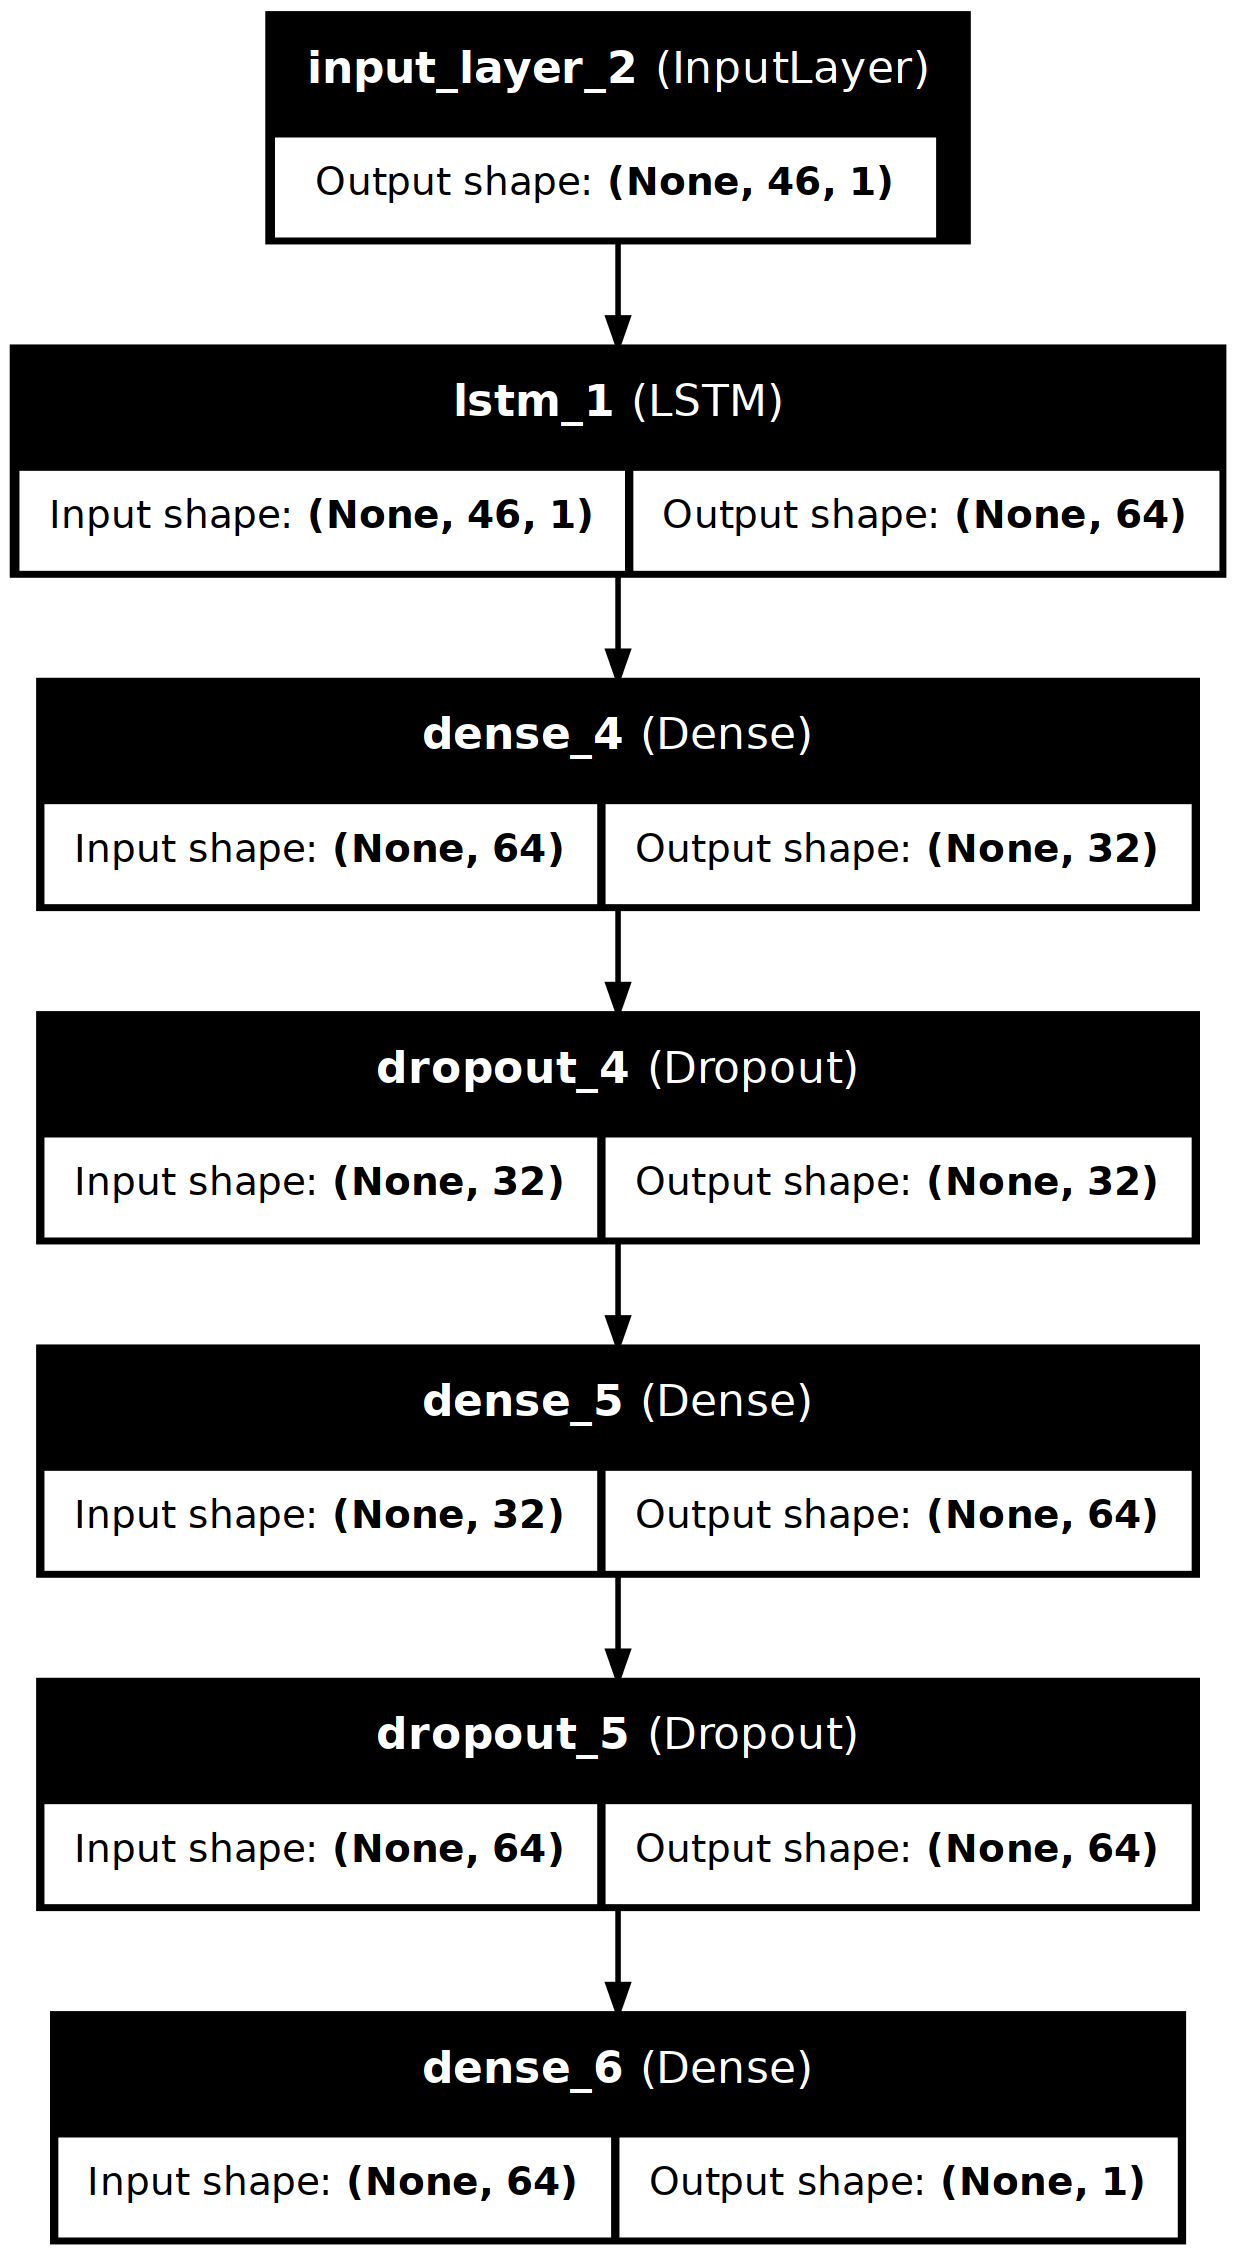

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot

from keras.models import load_model

cnn_loaded = load_model('../../models/cnn_ciciot_updated_model.keras')
lstm_loaded = load_model('../../models/lstm_ciciot_updated_model.keras')
ae_lstm_loaded = load_model('../../models/ae-lstm_ciciot_updated_model.keras')

plot_model(cnn_loaded, to_file='../../results/CICIOT_updated/models/CNN_model.png', show_shapes=True, show_layer_names=True)
plot_model(lstm_loaded, to_file='../../results/CICIOT_updated/models/LSTM_model.png', show_shapes=True, show_layer_names=True)
plot_model(ae_lstm_loaded, to_file='../../results/CICIOT_updated/models/AE-LSTM_model.png', show_shapes=True, show_layer_names=True)

### CNN metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98     34081
     Attacks       1.00      0.97      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0638
Test Accuracy: 0.9831


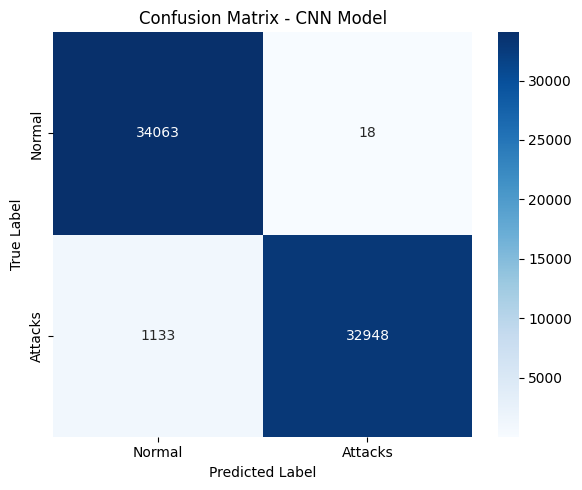

Attacks detected (True Positive) : 32948
Normal traffic detected (True Negative) : 34063
Attacks missed (False Negative) : 1133
False alarms (False Positive) : 18


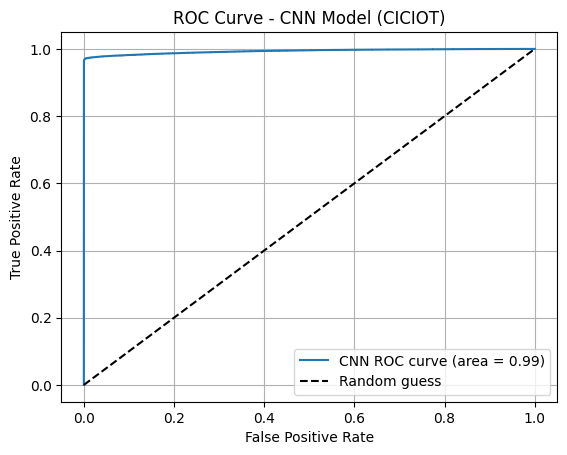

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/models/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/models/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### LSTM metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98     34081
     Attacks       1.00      0.96      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0638
Test Accuracy: 0.9831


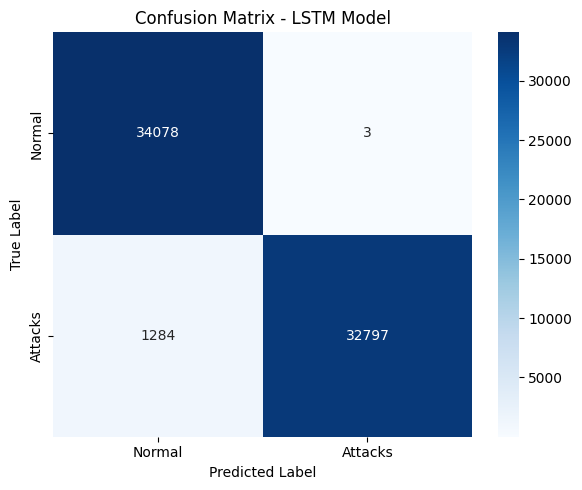

Attacks detected (True Positive) : 32797
Normal traffic detected (True Negative) : 34078
Attacks missed (False Negative) : 1284
False alarms (False Positive) : 3


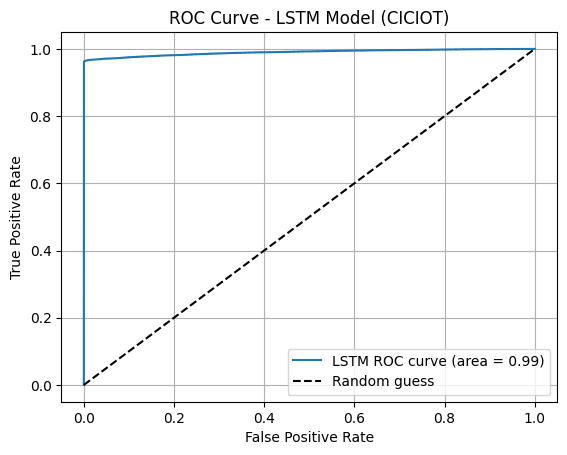

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/models/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/models/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


### AE-LSTM metrics

2131/2131 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98     34081
     Attacks       1.00      0.96      0.98     34081

    accuracy                           0.98     68162
   macro avg       0.98      0.98      0.98     68162
weighted avg       0.98      0.98      0.98     68162

Test Loss: 0.0638
Test Accuracy: 0.9831


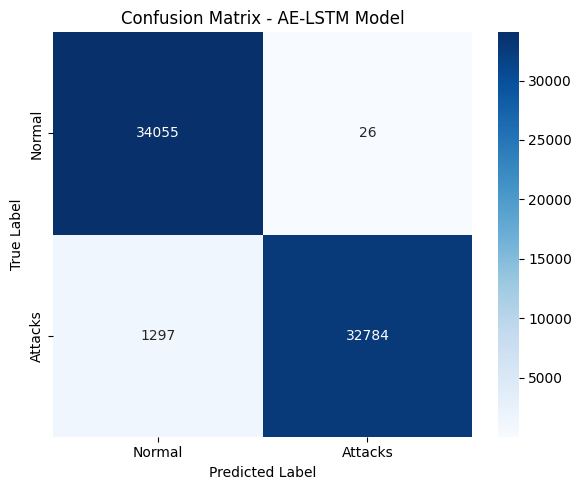

Attacks detected (True Positive) : 32784
Normal traffic detected (True Negative) : 34055
Attacks missed (False Negative) : 1297
False alarms (False Positive) : 26


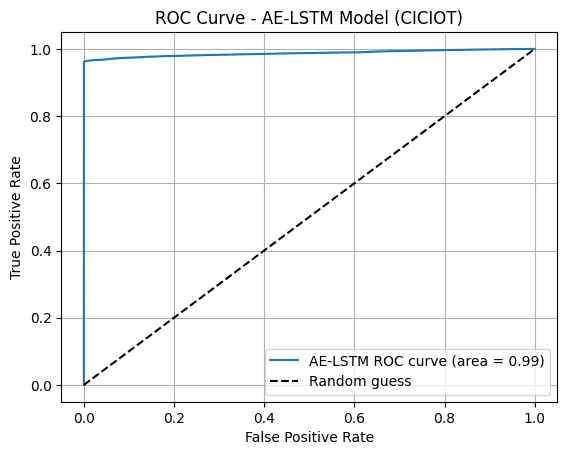

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/CICIOT_updated/models/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (CICIOT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/CICIOT_updated/models/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()